# Phân loại người sống sót trên tàu Titanic
--------------------------------------------

## 1. Định nghĩa vấn đề (Define Problem)
+ **Mô tả**:
- Bộ dữ liệu Titanic chứa thông tin về các hành khách trên con tàu Titanic, bao gồm nhân khẩu học, hạng vé, giá vé và thông tin sinh tồn.
- Mục tiêu của bài toán là dự đoán khả năng sống sót của hành khách dựa trên các đặc trưng cá nhân và vé tàu.
- Đây là một bài toán phân loại nhị phân (binary classification) — mỗi hành khách hoặc sống sót (1) hoặc không sống sót (0).

+ **Dữ liệu đầu vào (Input Features)**:
- Pclass: Hạng vé của hành khách (1, 2, 3)
- Sex: Giới tính của hành khách (nam/nữ)
- Age: Tuổi của hành khách
- SibSp: Số lượng anh/chị/em hoặc vợ/chồng đi cùng
- Parch: Số lượng cha/mẹ hoặc con đi cùng
- Fare: Giá vé hành khách đã trả
- Embarked: Cảng lên tàu (C = Cherbourg, Q = Queenstown, S = Southampton)
- Ngoài ra, có thể tạo thêm các đặc trưng mới như:
FamilySize (kích thước gia đình),
IsAlone (đi một mình hay không),
Title (danh xưng trích từ tên),
HasCabin (có thông tin cabin hay không).
+ **Kết quả đầu ra (Output / Target)**:
- Survived: Biến mục tiêu thể hiện trạng thái của hành khách
- 0: Không sống sót
- 1: Sống sót

## 2. Chuẩn bị vấn đề (Prepare Problem)

### Khai báo thư viện (Load Libraries)

In [1]:
# Load libraries
import os, sys
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import joblib

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import train_test_split

import warnings


### Tham số chương trình

In [2]:
# params
seed = 42  # random seed để tái dựng lại thực nghiệm giống nhau

exps_dir = "./exps"
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/feature1"
os.makedirs(save_dir, exist_ok=True)

print(os.path.abspath(save_dir))


d:\Nguyen Duc Quang\LAP TRINH HUONG DOI TUONG\titanic\exps\feature1


### Nạp dữ liệu (Load Dataset)

In [3]:

train_df = pd.read_csv("train.csv", index_col="PassengerId")
test_df = pd.read_csv("test.csv", index_col="PassengerId")
display.display(train_df.head())
display.display(train_df.tail())

Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked  
PassengerId                                                          
1                1      0         A/5 21171   7.2500   NaN        S  
2                1      0          PC 17599  71.2833   C85        C  
3                0      0  STON/O2. 3101282   7.9250   NaN        S  
4                1      0            113803  53.1000  C123        S  
5                0      0            373450   8.0500   NaN        S

Survived  Pclass                                      Name  \
PassengerId                                                               
887                 0       2                     Montvila, Rev. Juozas   
888                 1       1              Graham, Miss. Margaret Edith   
889                 0       3  Johnston, Miss. Catherine Helen "Carrie"   
890                 1       1                     Behr, Mr. Karl Howell   
891                 0       3                       Dooley, Mr. Patrick   

                Sex   Age  SibSp  Parch      Ticket   Fare Cabin Embarked  
PassengerId                                                                
887            male  27.0      0      0      211536  13.00   NaN        S  
888          female  19.0      0      0      112053  30.00   B42        S  
889          female   NaN      1      2  W./C. 6607  23.45   NaN        S  
890            male  26.0      0      0      111369  30.00  C148        C  
891            male  32.0      0      0      370376   7.75   NaN        Q

### Chia dữ liệu thực nghiệm

+ Dữ liệu ban đầu: thường được chia thành 70% để huấn luyện (Train) và 30% để kiểm tra (Test).
Tuy nhiên, trong bài toán Titanic, Kaggle đã cung cấp sẵn hai tập dữ liệu (train.csv và test.csv),
vì vậy chúng ta không cần chia lại.

+ Dữ liệu Train: được sử dụng để huấn luyện mô hình theo chiến lược K-Fold với k = 5.
Phương pháp này giúp đảm bảo mô hình được đánh giá công bằng, hạn chế hiện tượng overfitting và phản ánh đúng khả năng tổng quát hóa.


## 3. Tạo đặc trưng mới (Feature Engineering)

### (1) Tạo FamilySize = số người thân + 1 (bản thân)

SibSp  Parch  FamilySize Family_cate
0      1      0           2       Small
1      1      0           2       Small
2      0      0           1       Alone
3      1      0           2       Small
4      0      0           1       Alone
5      0      0           1       Alone
6      0      0           1       Alone
7      3      1           5      Medium
8      0      2           3       Small
9      1      0           2       Small

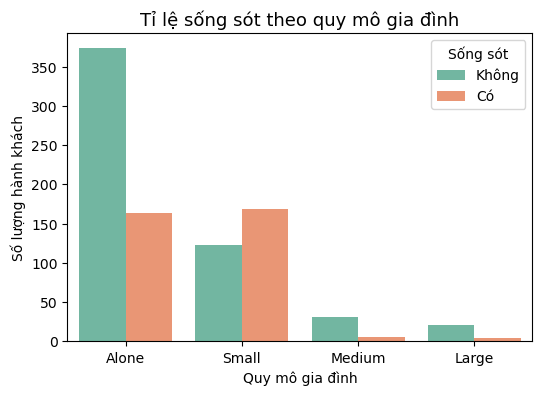

In [4]:
import pandas as pd

# Đọc dữ liệu train
train_df = pd.read_csv("train.csv")
# Tạo biến FamilySize
train_df['FamilySize'] = train_df['SibSp'].astype(int) + train_df['Parch'].astype(int) + 1

# Tạo cột Family_cate - phân nhóm quy mô gia đình
train_df['Family_cate'] = pd.cut(
    train_df['FamilySize'],
    bins=[0, 1, 4, 6, 20],
    labels=['Alone', 'Small', 'Medium', 'Large']
)

# Hiển thị một phần dữ liệu
display.display(train_df[['SibSp', 'Parch', 'FamilySize','Family_cate']].head(10))

# Minh họa tỉ lệ sống sót theo quy mô gia đình
plt.figure(figsize=(6,4))
sns.countplot(data=train_df, x='Family_cate', hue='Survived', palette='Set2')
plt.title("Tỉ lệ sống sót theo quy mô gia đình", fontsize=13)
plt.xlabel("Quy mô gia đình")
plt.ylabel("Số lượng hành khách")
plt.legend(title='Sống sót', labels=['Không', 'Có'])
plt.show()


**Nhận xét**

+ Đối với những hành khách đi một mình, khả năng sống sót rất thấp — có thể do trong tình huống khẩn cấp, họ không có người hỗ trợ hoặc không được chú ý đến.
+ Những gia đình nhỏ (2–4 người) có tỉ lệ sống sót cao hơn rõ rệt. Khi tai nạn xảy ra, họ dễ dàng kiểm soát số lượng thành viên và hỗ trợ nhau thoát nạn.
+ Ngược lại, các gia đình vừa và lớn (5–20 người) lại có tỉ lệ sống sót thấp, có thể vì quá đông người khiến việc hỗ trợ lẫn nhau trở nên khó khăn trong tình huống hỗn loạn.

### (2) Tạo cột Titles(danh xưng)

In [5]:
import re

def extract_title(name):
    p = re.compile(r",([\w\s]+)\.")
    return p.search(name).group(1).strip()
train_df['Title'] = train_df['Name'].apply(extract_title)
display.display(train_df.head())
display.display(train_df['Title'].value_counts())

test_df['Title'] = test_df['Name'].apply(extract_title)
display.display(test_df['Title'].value_counts())



PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  FamilySize Family_cate  \
0      0         A/5 21171   7.2500   NaN        S           2       Small   
1      0          PC 17599  71.2833   C85        C           2       Small   
2      0  STON/O2. 3101282   7.9250   NaN        S           1       Alone   
3      0            113803  53.1000  C123        S           2       Small   
4      0            373450   8.0500   NaN        S           1       Alone   

  Title  
0    Mr  
1   Mrs  
2  Miss  
3   Mrs  
4    Mr

Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Ms                1
Mme               1
Don               1
Lady              1
Sir               1
Capt              1
the Countess      1
Jonkheer          1
Name: count, dtype: int64

Title
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: count, dtype: int64

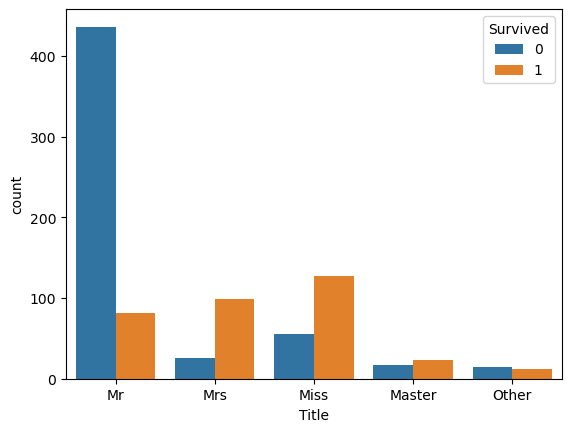

In [6]:
train_df['Title'] = train_df['Title'].apply(lambda x: x if x in ['Mr', 'Miss', 'Mrs', 'Master'] else 'Other')
sns.countplot(data=train_df, x='Title', hue='Survived')

test_df['Title'] = test_df['Title'].apply(lambda x: x if x in ['Mr', 'Miss', 'Mrs', 'Master'] else 'Other')

**Nhận xét**

+ Hành khách mang danh xưng Miss và Mrs có tỉ lệ sống sót cao hơn rõ rệt
→ phù hợp với chính sách “phụ nữ và trẻ em được cứu trước”.
+ Master (trẻ em nam) cũng có khả năng sống sót khá cao.
+ Trong khi đó, Mr (nam giới trưởng thành) là nhóm có tỉ lệ sống sót thấp nhất.
+ Nhóm Other (các danh xưng hiếm) chiếm tỉ lệ nhỏ, nên gộp chung để giảm nhiễu dữ liệu.

## 4. Tiền xử lý dữ liệu (Data Preprocessing)

### Làm sạch dữ liệu (Data Cleaning)

#### Tạo bảng dữ liệu làm sạch
+ Chỉ giữ lại các cột Input, Ouput

#### Xóa dữ liệu trùng nhau

In [7]:
display.display(train_df[train_df.duplicated(keep = False)])
display.display(test_df[test_df.duplicated(keep = False)])

Empty DataFrame
Columns: [PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked, FamilySize, Family_cate, Title]
Index: []

Empty DataFrame
Columns: [Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked, Title]
Index: []

**Nhận xét**

Sau khi kiểm tra, không phát hiện bản ghi trùng lặp trong tập dữ liệu huấn luyện → dữ liệu đảm bảo tính duy nhất cho mỗi hành khách.

#### Xử lý giá trị rỗng, không hợp lệ

In [8]:
print("="*5, "Null Value", "="*5)
display.display(train_df.isnull().sum())

print("="*5, "Checking NaN", "="*5)
display.display(train_df.isna().sum())

===== Null Value =====


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
FamilySize       0
Family_cate      0
Title            0
dtype: int64

===== Checking NaN =====


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
FamilySize       0
Family_cate      0
Title            0
dtype: int64

**Nhận xét**

+ Kết quả từ hai lệnh isnull().sum() và isna().sum() là tương tự nhau, vì cả hai đều dùng để kiểm tra giá trị khuyết (missing values) trong dữ liệu.
+ Bảng hiển thị cho biết số lượng giá trị null/NaN ở từng cột — nếu một cột có nhiều giá trị bị thiếu, ta cần xử lý trước khi huấn luyện mô hình (ví dụ: loại bỏ, thay thế bằng trung bình, trung vị hoặc giá trị phổ biến nhất).
+ Nếu tất cả giá trị đều bằng 0, nghĩa là bộ dữ liệu hoàn chỉnh, không có giá trị bị thiếu.

##### Xử lý giá trị bị thiếu

+ Age: thay các giá trị bị thiếu bằng giá trị trung bình của toàn bộ cột. Điều này giúp giảm thiểu sai lệch mà vẫn giữ lại được dữ liệu cho việc huấn luyện.
+ Embarked: các dòng bị thiếu sẽ được thay bằng giá trị có tần suất xuất hiện cao nhất (mode), vì đây là cột phân loại có ý nghĩa danh mục.
+ Cabin: cột này có quá nhiều giá trị bị thiếu, nên nếu giữ lại có thể ảnh hưởng đến chất lượng mô hình. Vì vậy, ta loại bỏ toàn bộ cột này để đảm bảo dữ liệu sạch và ổn định hơn.

In [9]:
# ===== Xử lý giá trị bị thiếu =====
# Train set
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].median())
train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])
train_df.drop(columns=['Cabin'], inplace=True, errors='ignore')

# Test set
test_df['Age'] = test_df['Age'].fillna(test_df['Age'].median())
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].median())
test_df.drop(columns=['Cabin'], inplace=True, errors='ignore')

# ===== Kiểm tra lại sau khi xử lý =====
print("="*10, "Missing values in Train", "="*10)
display.display(train_df.isnull().sum())

print("="*10, "Missing values in Test", "="*10)
display.display(test_df.isnull().sum())


========== Missing values in Train ==========


PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
FamilySize     0
Family_cate    0
Title          0
dtype: int64

========== Missing values in Test ==========


Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
Title       0
dtype: int64

### Loại bỏ các cột không cần thiết
Các cột **Name** và **Ticket** không còn hữu ích cho mô hình sau khi đã trích xuất thông tin từ chúng.


In [10]:
# Loại bỏ các cột không cần thiết
train_df.drop(columns=['Name', 'Ticket'], inplace=True, errors='ignore')
test_df.drop(columns=['Name', 'Ticket'], inplace=True, errors='ignore')

# Hiển thị 5 dòng đầu để kiểm tra lại cấu trúc dữ liệu
display.display(train_df.head())


PassengerId  Survived  Pclass     Sex   Age  SibSp  Parch     Fare  \
0            1         0       3    male  22.0      1      0   7.2500   
1            2         1       1  female  38.0      1      0  71.2833   
2            3         1       3  female  26.0      0      0   7.9250   
3            4         1       1  female  35.0      1      0  53.1000   
4            5         0       3    male  35.0      0      0   8.0500   

  Embarked  FamilySize Family_cate Title  
0        S           2       Small    Mr  
1        C           2       Small   Mrs  
2        S           1       Alone  Miss  
3        S           2       Small   Mrs  
4        S           1       Alone    Mr

In [11]:
#Lưu lại tập test đã xư lý
test_df.to_csv(os.path.join(save_dir, "test_preprocessed.csv"))

### Biến đổi dữ liệu (Data Transforms)

#### Chuyển đổi dữ liệu danh mục (Category) thành dữ liệu số

In [12]:
def Colum_encoder(df, Column_name):
    encoder = LabelEncoder()
    df[Column_name] = encoder.fit_transform(df[Column_name])
    encoder_name = encoder.classes_
    return encoder, encoder_name

for i in ["Sex", "Embarked", "Title", "Family_cate"]:
    train_df[i] = train_df[i].astype(str)
    encoder, names = Colum_encoder(train_df, i)
    print(f"Unique values in {i} after encoding: {names}")
    # Save encoders
    joblib.dump(encoder, f'{save_dir}/{i}_encoder.joblib')
    # Load and check again
    loaded_encoder = joblib.load(f'{save_dir}/{i}_encoder.joblib')
    print(f"Loaded {i} Encoder Classes:")
    print(loaded_encoder.classes_)


Unique values in Sex after encoding: ['female' 'male']
Loaded Sex Encoder Classes:
['female' 'male']
Unique values in Embarked after encoding: ['C' 'Q' 'S']
Loaded Embarked Encoder Classes:
['C' 'Q' 'S']
Unique values in Title after encoding: ['Master' 'Miss' 'Mr' 'Mrs' 'Other']
Loaded Title Encoder Classes:
['Master' 'Miss' 'Mr' 'Mrs' 'Other']
Unique values in Family_cate after encoding: ['Alone' 'Large' 'Medium' 'Small']
Loaded Family_cate Encoder Classes:
['Alone' 'Large' 'Medium' 'Small']


In [13]:
display.display(train_df)

PassengerId  Survived  Pclass  Sex   Age  SibSp  Parch     Fare  \
0              1         0       3    1  22.0      1      0   7.2500   
1              2         1       1    0  38.0      1      0  71.2833   
2              3         1       3    0  26.0      0      0   7.9250   
3              4         1       1    0  35.0      1      0  53.1000   
4              5         0       3    1  35.0      0      0   8.0500   
..           ...       ...     ...  ...   ...    ...    ...      ...   
886          887         0       2    1  27.0      0      0  13.0000   
887          888         1       1    0  19.0      0      0  30.0000   
888          889         0       3    0  28.0      1      2  23.4500   
889          890         1       1    1  26.0      0      0  30.0000   
890          891         0       3    1  32.0      0      0   7.7500   

     Embarked  FamilySize  Family_cate  Title  
0           2           2            3      2  
1           0           2            3      3  
2           2           1            0      1  
3           2           2            3      3  
4           2           1            0      2  
..        ...         ...          ...    ...  
886         2           1            0      4  
887         2           1            0      1  
888         2           4            3      1  
889         0           1            0      2  
890         1           1            0      2  

[891 rows x 12 columns]

#### Chuyển đổi dữ liệu danh mục (Category) thành dạng OneHot

Một số thuật toán khi chuyển đổi cột dạng danh mục thành kiểu OneHot thì cho hiệu suất cao hơn.

Bên cạnh đó, khi huấn luyện mô hình với dạng hàm mất mát Categorical Cross Entropy thì cũng cần chuyển thuộc tính phân lớp sang dạng OneHot.

In [14]:
def One_Hot_Encoding(df, column_name):
    # Thực hiện One-Hot Encoding
    dummies = pd.get_dummies(df[column_name], prefix=column_name)
    dummies = dummies.astype(int)
    df= pd.DataFrame(dummies.values, columns=dummies.columns)
    return df
df_onehot_S= One_Hot_Encoding(train_df,"Sex")
display.display(df_onehot_S)

Sex_0  Sex_1
0        0      1
1        1      0
2        1      0
3        1      0
4        0      1
..     ...    ...
886      0      1
887      1      0
888      1      0
889      0      1
890      0      1

[891 rows x 2 columns]

#### Chuẩn hóa dữ liệu (Data Normalization)
Chuẩn hóa dữ liệu giúp các thuộc tính có cùng miền giá trị, tránh việc một số biến có thang đo lớn (như Fare) chi phối quá trình huấn luyện.
Hai phương pháp thường được sử dụng:
+ Min-Max Normalization
$$
z = \frac{x - min(x)}{max(x) - min(x)}
$$
+ Standard Normalization
$$
z = \frac{x - \mu}{\sigma}
$$
Lưu ý: Việc chuẩn hóa thường được thực hiện trong giai đoạn tiền xử lý hoặc trong pipeline huấn luyện để đảm bảo tính nhất quán giữa tập Train và Test.

##### Min-Max Normalization

In [15]:
# Min-Max Normalization
scale_columns = ["Age", "Fare", "SibSp", "Parch"]
minmax_scaler = MinMaxScaler()
minmax_scaler.fit(train_df[scale_columns])
df_minmax = train_df.copy()
df_minmax[scale_columns] = minmax_scaler.transform(train_df[scale_columns])
display.display(df_minmax)

PassengerId  Survived  Pclass  Sex       Age  SibSp     Parch      Fare  \
0              1         0       3    1  0.271174  0.125  0.000000  0.014151   
1              2         1       1    0  0.472229  0.125  0.000000  0.139136   
2              3         1       3    0  0.321438  0.000  0.000000  0.015469   
3              4         1       1    0  0.434531  0.125  0.000000  0.103644   
4              5         0       3    1  0.434531  0.000  0.000000  0.015713   
..           ...       ...     ...  ...       ...    ...       ...       ...   
886          887         0       2    1  0.334004  0.000  0.000000  0.025374   
887          888         1       1    0  0.233476  0.000  0.000000  0.058556   
888          889         0       3    0  0.346569  0.125  0.333333  0.045771   
889          890         1       1    1  0.321438  0.000  0.000000  0.058556   
890          891         0       3    1  0.396833  0.000  0.000000  0.015127   

     Embarked  FamilySize  Family_cate  Title  
0           2           2            3      2  
1           0           2            3      3  
2           2           1            0      1  
3           2           2            3      3  
4           2           1            0      2  
..        ...         ...          ...    ...  
886         2           1            0      4  
887         2           1            0      1  
888         2           4            3      1  
889         0           1            0      2  
890         1           1            0      2  

[891 rows x 12 columns]

In [16]:
minmax_scaler.__dict__

{'feature_range': (0, 1),
 'copy': True,
 'clip': False,
 'feature_names_in_': array(['Age', 'Fare', 'SibSp', 'Parch'], dtype=object),
 'n_features_in_': 4,
 'n_samples_seen_': 891,
 'scale_': array([0.01256597, 0.00195187, 0.125     , 0.16666667]),
 'min_': array([-0.00527771,  0.        ,  0.        ,  0.        ]),
 'data_min_': array([0.42, 0.  , 0.  , 0.  ]),
 'data_max_': array([ 80.    , 512.3292,   8.    ,   6.    ]),
 'data_range_': array([ 79.58  , 512.3292,   8.    ,   6.    ])}

In [17]:
# Save encoders
joblib.dump(minmax_scaler, f'{save_dir}/minmax_scaler.joblib')

['./exps/feature1/minmax_scaler.joblib']

In [18]:
joblib.load(f'{save_dir}/minmax_scaler.joblib').__dict__

{'feature_range': (0, 1),
 'copy': True,
 'clip': False,
 'feature_names_in_': array(['Age', 'Fare', 'SibSp', 'Parch'], dtype=object),
 'n_features_in_': 4,
 'n_samples_seen_': 891,
 'scale_': array([0.01256597, 0.00195187, 0.125     , 0.16666667]),
 'min_': array([-0.00527771,  0.        ,  0.        ,  0.        ]),
 'data_min_': array([0.42, 0.  , 0.  , 0.  ]),
 'data_max_': array([ 80.    , 512.3292,   8.    ,   6.    ]),
 'data_range_': array([ 79.58  , 512.3292,   8.    ,   6.    ])}

In [19]:
# save scale_columns
np.savez(f'{save_dir}/scale_columns.npz', scale_columns = scale_columns)
dict(np.load(f'{save_dir}/scale_columns.npz'))

{'scale_columns': array(['Age', 'Fare', 'SibSp', 'Parch'], dtype='<U5')}

<Axes: >

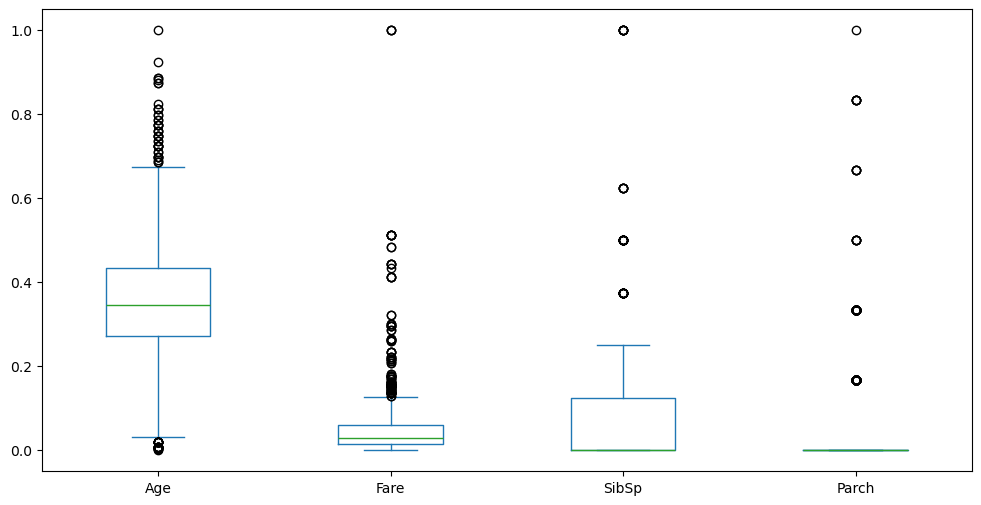

In [20]:
df_minmax[scale_columns].plot(kind="box", figsize=(12,6))

##### Standard Normalization

In [21]:
# Standard Normalization
standard_scaler = StandardScaler()
standard_scaler.fit(train_df[scale_columns])
df_standard = train_df.copy()
df_standard[scale_columns] = standard_scaler.transform(train_df[scale_columns])
display.display(df_standard)

PassengerId  Survived  Pclass  Sex       Age     SibSp     Parch  \
0              1         0       3    1 -0.565736  0.432793 -0.473674   
1              2         1       1    0  0.663861  0.432793 -0.473674   
2              3         1       3    0 -0.258337 -0.474545 -0.473674   
3              4         1       1    0  0.433312  0.432793 -0.473674   
4              5         0       3    1  0.433312 -0.474545 -0.473674   
..           ...       ...     ...  ...       ...       ...       ...   
886          887         0       2    1 -0.181487 -0.474545 -0.473674   
887          888         1       1    0 -0.796286 -0.474545 -0.473674   
888          889         0       3    0 -0.104637  0.432793  2.008933   
889          890         1       1    1 -0.258337 -0.474545 -0.473674   
890          891         0       3    1  0.202762 -0.474545 -0.473674   

         Fare  Embarked  FamilySize  Family_cate  Title  
0   -0.502445         2           2            3      2  
1    0.786845         0           2            3      3  
2   -0.488854         2           1            0      1  
3    0.420730         2           2            3      3  
4   -0.486337         2           1            0      2  
..        ...       ...         ...          ...    ...  
886 -0.386671         2           1            0      4  
887 -0.044381         2           1            0      1  
888 -0.176263         2           4            3      1  
889 -0.044381         0           1            0      2  
890 -0.492378         1           1            0      2  

[891 rows x 12 columns]

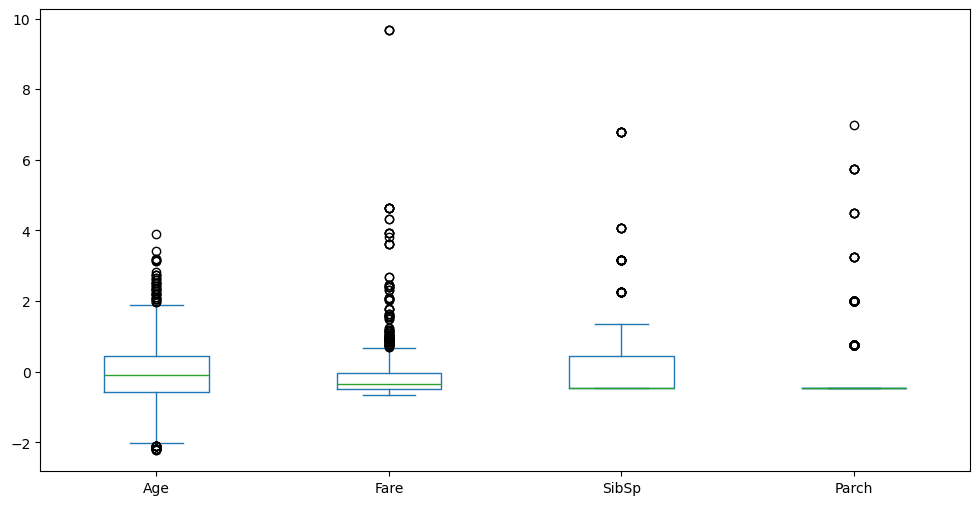

In [22]:
df_standard[scale_columns].plot(kind="box", figsize=(12,6));

In [23]:
numeric_df = df_standard.select_dtypes(include=['float64', 'int64'])
# compute correlations only on numeric columns to avoid converting string columns to float
correlations = numeric_df.corr(method='pearson')
display.display(correlations)

PassengerId  Survived    Pclass       Sex       Age     SibSp  \
PassengerId     1.000000 -0.005007 -0.035144  0.042939  0.034212 -0.057527   
Survived       -0.005007  1.000000 -0.338481 -0.543351 -0.064910 -0.035322   
Pclass         -0.035144 -0.338481  1.000000  0.131900 -0.339898  0.083081   
Sex             0.042939 -0.543351  0.131900  1.000000  0.081163 -0.114631   
Age             0.034212 -0.064910 -0.339898  0.081163  1.000000 -0.233296   
SibSp          -0.057527 -0.035322  0.083081 -0.114631 -0.233296  1.000000   
Parch          -0.001652  0.081629  0.018443 -0.245489 -0.172482  0.414838   
Fare            0.012658  0.257307 -0.549500 -0.182333  0.096688  0.159651   
Embarked        0.013128 -0.167675  0.162098  0.108262 -0.018754  0.068230   
FamilySize     -0.040143  0.016639  0.065997 -0.200988 -0.245619  0.890712   
Family_cate    -0.046476  0.246084 -0.186708 -0.293691 -0.127178  0.402984   
Title           0.085016 -0.052471 -0.195910  0.040484  0.465859 -0.213887   

                Parch      Fare  Embarked  FamilySize  Family_cate     Title  
PassengerId -0.001652  0.012658  0.013128   -0.040143    -0.046476  0.085016  
Survived     0.081629  0.257307 -0.167675    0.016639     0.246084 -0.052471  
Pclass       0.018443 -0.549500  0.162098    0.065997    -0.186708 -0.195910  
Sex         -0.245489 -0.182333  0.108262   -0.200988    -0.293691  0.040484  
Age         -0.172482  0.096688 -0.018754   -0.245619    -0.127178  0.465859  
SibSp        0.414838  0.159651  0.068230    0.890712     0.402984 -0.213887  
Parch        1.000000  0.216225  0.039798    0.783111     0.445335 -0.122792  
Fare         0.216225  1.000000 -0.224719    0.217138     0.254738 -0.009068  
Embarked     0.039798 -0.224719  1.000000    0.066516    -0.098713 -0.011509  
FamilySize   0.783111  0.217138  0.066516    1.000000     0.497908 -0.207530  
Family_cate  0.445335  0.254738 -0.098713    0.497908     1.000000  0.032088  
Title       -0.122792 -0.009068 -0.011509   -0.207530     0.032088  1.000000

In [24]:
standard_scaler.__dict__

{'with_mean': True,
 'with_std': True,
 'copy': True,
 'feature_names_in_': array(['Age', 'Fare', 'SibSp', 'Parch'], dtype=object),
 'n_features_in_': 4,
 'n_samples_seen_': np.int64(891),
 'mean_': array([29.36158249, 32.20420797,  0.52300786,  0.38159371]),
 'var_': array([1.69322249e+02, 2.46666531e+03, 1.21467827e+00, 6.48999031e-01]),
 'scale_': array([13.01238827, 49.66553444,  1.10212444,  0.80560476])}

In [25]:
# Save encoders
joblib.dump(standard_scaler, f'{save_dir}/standard_scaler.joblib')

['./exps/feature1/standard_scaler.joblib']

In [26]:
joblib.load(f'{save_dir}/standard_scaler.joblib').__dict__

{'with_mean': True,
 'with_std': True,
 'copy': True,
 'feature_names_in_': array(['Age', 'Fare', 'SibSp', 'Parch'], dtype=object),
 'n_features_in_': 4,
 'n_samples_seen_': np.int64(891),
 'mean_': array([29.36158249, 32.20420797,  0.52300786,  0.38159371]),
 'var_': array([1.69322249e+02, 2.46666531e+03, 1.21467827e+00, 6.48999031e-01]),
 'scale_': array([13.01238827, 49.66553444,  1.10212444,  0.80560476])}

### Lưu dữ liệu Features

+ Chuyển đổi dữ liệu sang dạng numpy với phần Input (X_data), Output (y_data)
+ Lưu tất cả thông tin để chuẩn bị chạy thuật toán

In [27]:
# MinMax
x_train = df_minmax.values[:, :-1]
y_train = df_minmax.values[:, -1]
display.display(df_minmax.head())

print("+ x_train: \n ", x_train[:5, :])
print("+ y_train: \n ", y_train[:5])

np.savez(f'{save_dir}/feat_minmax.npz', x_train = x_train, y_train = y_train)
df_minmax.to_excel(f'{save_dir}/df_minmax.xlsx', index=False)

PassengerId  Survived  Pclass  Sex       Age  SibSp  Parch      Fare  \
0            1         0       3    1  0.271174  0.125    0.0  0.014151   
1            2         1       1    0  0.472229  0.125    0.0  0.139136   
2            3         1       3    0  0.321438  0.000    0.0  0.015469   
3            4         1       1    0  0.434531  0.125    0.0  0.103644   
4            5         0       3    1  0.434531  0.000    0.0  0.015713   

   Embarked  FamilySize  Family_cate  Title  
0         2           2            3      2  
1         0           2            3      3  
2         2           1            0      1  
3         2           2            3      3  
4         2           1            0      2

+ x_train: 
  [[1.         0.         3.         1.         0.27117366 0.125
  0.         0.01415106 2.         2.         3.        ]
 [2.         1.         1.         0.         0.4722292  0.125
  0.         0.13913574 0.         2.         3.        ]
 [3.         1.         3.         0.         0.32143755 0.
  0.         0.01546857 2.         1.         0.        ]
 [4.         1.         1.         0.         0.43453129 0.125
  0.         0.1036443  2.         2.         3.        ]
 [5.         0.         3.         1.         0.43453129 0.
  0.         0.01571255 2.         1.         0.        ]]
+ y_train: 
  [2. 3. 1. 3. 2.]


In [28]:
x_train = df_standard.values[:, :-1]
y_train = df_standard.values[:, -1]
display.display(df_standard.head())

print("+ x_train: \n ", x_train[:5, :])
print("+ y_train: \n ", y_train[:5])

np.savez(f'{save_dir}/feat_standard.npz', x_train = x_train, y_train = y_train) #luu dữ liệu đã chuẩn hóa
df_minmax.to_excel(f'{save_dir}/df_standard.xlsx', index=False)

PassengerId  Survived  Pclass  Sex       Age     SibSp     Parch      Fare  \
0            1         0       3    1 -0.565736  0.432793 -0.473674 -0.502445   
1            2         1       1    0  0.663861  0.432793 -0.473674  0.786845   
2            3         1       3    0 -0.258337 -0.474545 -0.473674 -0.488854   
3            4         1       1    0  0.433312  0.432793 -0.473674  0.420730   
4            5         0       3    1  0.433312 -0.474545 -0.473674 -0.486337   

   Embarked  FamilySize  Family_cate  Title  
0         2           2            3      2  
1         0           2            3      3  
2         2           1            0      1  
3         2           2            3      3  
4         2           1            0      2

+ x_train: 
  [[ 1.          0.          3.          1.         -0.56573646  0.43279337
  -0.47367361 -0.50244517  2.          2.          3.        ]
 [ 2.          1.          1.          0.          0.66386103  0.43279337
  -0.47367361  0.78684529  0.          2.          3.        ]
 [ 3.          1.          3.          0.         -0.25833709 -0.4745452
  -0.47367361 -0.48885426  2.          1.          0.        ]
 [ 4.          1.          1.          0.          0.4333115   0.43279337
  -0.47367361  0.42073024  2.          2.          3.        ]
 [ 5.          0.          3.          1.          0.4333115  -0.4745452
  -0.47367361 -0.48633742  2.          1.          0.        ]]
+ y_train: 
  [2. 3. 1. 3. 2.]


# Kết thúc

In [29]:
cur_dir = os.getcwd()  # lấy đường dẫn hiện tại
notebook_path = os.path.join(cur_dir, "preprocessing1.ipynb")

# Kiểm tra xem file có tồn tại không
if os.path.exists(notebook_path):
    !jupyter nbconvert "{notebook_path}" --to html
else:
    print("Không tìm thấy file preprocessing1.ipynb.")


[NbConvertApp] Converting notebook d:\Nguyen Duc Quang\LAP TRINH HUONG DOI TUONG\titanic\preprocessing1.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 494442 bytes to d:\Nguyen Duc Quang\LAP TRINH HUONG DOI TUONG\titanic\preprocessing1.html
